In [1]:
import torch
from src.configs import *
from src.gan_models import *
import time
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cpu'
# Check if MPS is supported and available
if torch.backends.mps.is_available():
    print("MPS is available on this device.")
    device = torch.device("mps")  # Use MPS device
else:
    print("MPS not available, using CPU instead.")
    device = torch.device("cpu")  # Fallback to CPU

# device = torch.device('cpu')

MPS is available on this device.


# Load model

In [9]:
model_path = 'models/generator_model_sndcgan256_landscape_630.pt'
# model_path = 'models/generator_model_128_151.pt'


g_model = DCGANGeneratorNet256()  # Ensure the class is defined or imported

g_ckp = torch.load(model_path, map_location=device)
g_model.load_state_dict(g_ckp if 'gan_model_state_dict' not in g_ckp else g_ckp['gan_model_state_dict'])

g_model.to(device)
g_model.eval()  # Set to evaluation mode if not training further

DCGANGeneratorNet256(
  (cons_layers): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(128, 1, 1))
    (1): ConvTranspose2d(128, 2048, kernel_size=(4, 4), stride=(1, 1))
    (2): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): FReLU(inplace=True, bias=(torch.Size([1])))
    (4): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): FReLU(inplace=True, bias=(torch.Size([1])))
    (7): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): FReLU(inplace=True, bias=(torch.Size([1])))
    (10): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): FReLU(inplace=True, bias=(to

In [51]:
# g_model.to('cpu')
# torch.save(g_model.state_dict(), 'models/generator_model_impressionist_150_cpu.pth')

In [10]:
n_sample_points = 80

def create_trajectory(start, end, n_samples, device):
    direction = end - start
    trajectory = [start + (i * direction) / (n_samples + 1) for i in range(n_samples + 2)] 
    
    return trajectory 

def get_orthogonal_point(point):
    orthogonal = torch.linalg.svd(point)
    print(orthogonal.Vh)
    
def find_farest_point(point):
    max_attempt = 100
    test_point = torch.randn(1, LATENT_DIM).to(device)
    farest_point = test_point
    max_dist = 0
    for i in range(max_attempt):
        test_point = torch.randn(1, LATENT_DIM).to(device) 
        dist = torch.linalg.norm(point - test_point)
        if dist > max_dist:
            max_dist = dist
            farest_point = test_point
    
    print(f'Distance: {torch.linalg.norm(point - farest_point)}')
    return farest_point

def find_random_point(point):
    farest_point = torch.randn(1, LATENT_DIM).to(device)
    return farest_point


torch.manual_seed(0)
corners_2d = torch.zeros((4, LATENT_DIM))
corners_2d[0] = torch.randn(1, LATENT_DIM).to(device)
corners_2d[1] = corners_2d[0] * -1
corners_2d[2] = torch.randn(1, LATENT_DIM).to(device)
corners_2d[3] = corners_2d[2] * -1

def find_xx(ratio1, ratio2, device):
    # notes page 26
    ratio1 = torch.tensor(ratio1).float()
    ratio2 = torch.tensor(ratio2).float()
    
    ratio = torch.zeros((1, 4)).float()
    ratio[0, 0] = (1 - ratio1) * (1 - ratio2) / 4
    ratio[0, 1] = (1 + ratio1) * (1 - ratio2) / 4
    ratio[0, 2] = (1 + ratio1) * (1 + ratio2) / 4
    ratio[0, 3] = (1 - ratio1) * (1 + ratio2) / 4
    
    aa = torch.matmul(ratio, corners_2d).to(device)
    return aa

start_point = find_xx(-1, 1, device)
print(f'Start point: {start_point}')

end_point = find_xx(1, -1, device)

# start_point = torch.randn(1, LATENT_DIM).to(device)
# end_point = torch.randn(1, LATENT_DIM).to(device)
# end_point = find_farest_point(start_point)
# end_point = get_orthogonal_point(start_point) 
# start_point = torch.full((1, LATENT_DIM), -1, device=device)
# end_point = torch.full((1, LATENT_DIM), 1, device=device)

trajectory = create_trajectory(start_point, end_point, n_sample_points, device)

# tr2 = create_trajectory(end_point, find_xx(0.23, 0.8, device), n_sample_points, device)
# 
# trajectory = trajectory + tr2

print(f'Total Trajectory: {len(trajectory)}')

generated_images = []
cost_times = []

for idx, inter_point in enumerate(trajectory):
    start_ts = time.time()
    output = g_model(inter_point)
    img = output[0, :, :, :].detach().cpu().permute(1, 2, 0).numpy()
    normalized_img = (img + 1) / 2
    generated_images.append(normalized_img) 
    cost_ts = (time.time() - start_ts) * 1000
    cost_times.append(cost_ts) 
    print(f'[{idx}]Image generated in {cost_ts} ms')

print(f'Generated images: {len(generated_images)}')



Start point: tensor([[ 0.8834,  0.4189,  0.8048, -0.5656, -0.6104, -0.4669, -1.9507,  1.0631,
          0.0773, -0.1164,  0.5940,  1.2439,  0.1021,  1.0335,  0.3126, -0.2458,
          0.2596, -0.1183, -0.2440, -1.1646, -0.2886, -0.3866,  0.2011,  0.1179,
         -0.1922,  0.7722,  1.9003, -0.1307,  0.7043, -0.3147, -0.1574, -0.3854,
         -0.9671,  0.9911, -0.3016,  0.1073, -0.9985,  0.4987, -0.7611, -0.6183,
         -0.3140, -0.2133,  0.1201, -0.3605,  0.3140,  1.0787, -0.2408,  1.3962,
          0.0661,  0.3584,  1.5616,  0.3546, -1.0811, -0.1315, -1.5735, -0.7814,
          1.0787,  0.7209, -1.4708, -0.2756, -0.6668,  0.9944,  1.1894,  1.1959,
          0.5596, -0.5335, -0.4069, -0.3946, -0.1715, -0.8760,  0.2871, -1.0216,
          0.0744,  1.0922, -0.3920, -0.5945, -0.6623,  1.2063, -0.6074,  0.5472,
         -1.1711, -0.0975, -0.9634, -0.8403,  1.2537, -0.9868,  0.4947,  1.2830,
         -0.9552, -1.2836,  0.6659, -0.5651, -0.2877,  0.0334,  1.0619,  0.1144,
          0.343

RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

Text(0, 0.5, 'Time (ms)')

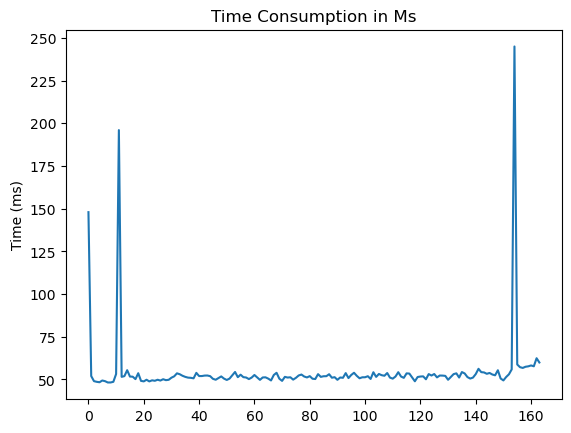

In [20]:
plt.plot(cost_times)
plt.title('Time Consumption in Ms')
plt.ylabel('Time (ms)')

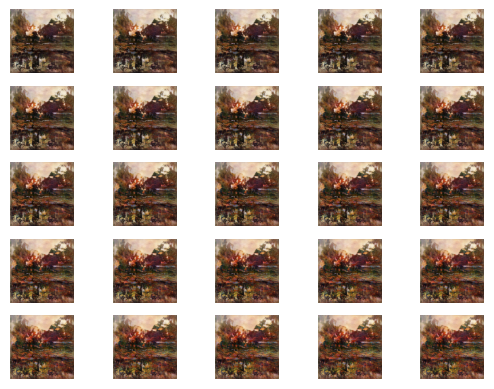

In [48]:
## Preview
n = 5
for i in range(n * n):
	# define subplot
	plt.subplot(n, n, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(generated_images[i])

In [49]:
import imageio
from PIL import Image
import numpy as np

# Specify the path for the output GIF
output_gif_path = 'gifs/wikiart_sndcgan256_test.gif'

new_width = 512
new_height = 512

with imageio.get_writer(output_gif_path, mode='I', duration=0.05) as writer:
    for image in generated_images:
        # Convert the NumPy array to a PIL Image object
        img = Image.fromarray((image * 255).astype(np.uint8))
        # Resize the image
        img = img.resize((new_width, new_height), Image.NEAREST)
        # Convert the PIL Image back to a NumPy array
        img_resized = np.array(img)
        # Append the resized image to the GIF
        writer.append_data(img_resized)

print("GIF saved at:", output_gif_path)

GIF saved at: gifs/wikiart_sndcgan256_test.gif
